In [3]:
import numpy as np
np.random.seed(42)

data = open('one_digit_plus.txt').read()
chars = list(set(data))
nc = len(chars)
char2idx = {ch:idx for idx, ch in enumerate(chars)}
idx2char = {idx:ch for idx, ch in enumerate(chars)}

# params
r = 0.01
sigma = 0.01
hn = 40
ufdl = 30
Wgx = np.random.randn(hn, nc) * sigma
Wgh = np.random.randn(hn, hn) * sigma
Bg = np.zeros([hn, 1])
Wix = np.random.randn(hn, nc) * sigma
Wih = np.random.randn(hn, hn) * sigma
Bi = np.zeros([hn, 1])
Wfx = np.random.randn(hn, nc) * sigma
Wfh = np.random.randn(hn, hn) * sigma
Bf = np.zeros([hn, 1])
Wox = np.random.randn(hn, nc) * sigma
Woh = np.random.randn(hn, hn) * sigma
Wos = np.random.randn(hn, hn) * sigma
Bo = np.zeros([hn, 1])
Wkh = np.random.randn(nc, hn) * sigma
Bk = np.zeros([nc, 1])

sigmoid = lambda x:  1.0 /(1.0 + np.exp(-x))
T = 1
softmax = lambda x: np.exp(x/T) / np.sum( np.exp(x/T))

def update(xdata, zdata, prevs, prevh):
    dWgx, dWgh, dWix, dWih = np.zeros_like(Wgx), np.zeros_like(Wgh), np.zeros_like(Wix), np.zeros_like(Wih)
    dWfx, dWfh, dWox, dWoh, dWos, dWkh = np.zeros_like(Wfx), np.zeros_like(Wfh), np.zeros_like(Wox), np.zeros_like(Woh), np.zeros_like(Wos), np.zeros_like(Wkh)
    dBg, dBi, dBf, dBo, dBk = np.zeros_like(Bg), np.zeros_like(Bi), np.zeros_like(Bf), np.zeros_like(Bo), np.zeros_like(Bk)
    
    # forward pass
    loss = 0
    Ykt, Ht, Gt, It, Ft, Ot, St = {},{},{},{},{},{},{}
    for t in range(ufdl):
        Xt = np.zeros([nc, 1])
        Xt[ char2idx[ xdata[t]] ] = 1
        Zt = np.zeros([nc, 1])
        Zt[ char2idx[ zdata[t]] ] = 1
        
        Gt[t] = sigmoid(Wgx.dot(Xt) + Wgh.dot(prevh) + Bg)
        It[t] = sigmoid(Wix.dot(Xt) + Wih.dot(prevh) + Bi)
        Ft[t] = sigmoid(Wfx.dot(Xt) + Wfh.dot(prevh) + Bf)
        Ot[t] = sigmoid(Wox.dot(Xt) + Woh.dot(prevh) + Bo) 
        
        St[t] = Gt[t] * It[t] + prevs * Ft[t]
        prevs = St[t]
        Ht[t] = sigmoid(St[t]) * Ot[t]
        prevh = Ht[t]
        Akt = Wkh.dot(Ht[t]) + Bk
        Ykt[t] = softmax(Akt)
        loss = loss - np.sum(Zt * np.log(Ykt[t]))
        
    # backward pass
    dGr, dIr, dFr, dOr, dSp1 = np.zeros_like(Gt[0]), np.zeros_like(It[0]), np.zeros_like(Ft[0]), np.zeros_like(Ot[0]), np.zeros_like(St[0])
    Gt[ufdl], It[ufdl], Ft[ufdl], Ot[ufdl] = np.zeros_like(Gt[0]), np.zeros_like(It[0]), np.zeros_like(Ft[0]), np.zeros_like(Ot[0])
    St[-1] = np.zeros_like(St[0])
    Ht[-1] = np.zeros_like(Ht[0])
    for t in np.arange(ufdl, 0, -1)-1:
        Xt = np.zeros([nc, 1])
        Xt[ char2idx[ xdata[t]] ] = 1
        Zt = np.zeros([nc, 1])
        Zt[ char2idx[ zdata[t]] ] = 1
        dKt = Ykt[t] - Zt
        dWkh += dKt.dot(np.transpose(Ht[t]))
        dBk += dKt
        dHt = ( np.transpose(Wkh).dot(dKt) + (np.transpose(Wgh).dot(dGr) + (np.transpose(Wih).dot(dIr)) +
                                             (np.transpose(Wfh).dot(dFr)) + (np.transpose(Woh).dot(dOr)) ))
        
        dOt = dHt * sigmoid(St[t])
        dSt = dHt * Ot[t] * sigmoid(St[t])*(1-sigmoid(St[t])) + dSp1 * Ft[t+1]
        dGt = dSt * It[t]
        dIt = dSt * Gt[t]
        dFt = dSt * St[t-1]
        
        dOr = dOt * Ot[t] * (1 - Ot[t]) 
        dWox += dOr.dot( np.transpose(Xt) )
        dWoh += dOr.dot( np.transpose(Ht[t-1]))
        dBo += dOr
        
        dFr = dFt * Ft[t] * (1 - Ft[t])
        dWfx += dFr.dot( np.transpose(Xt) )
        dWfh += dFr.dot( np.transpose(Ht[t-1]))
        dBf += dFr
        
        dIr = dIt * It[t] * (1 - It[t] )
        dWix += dIr.dot( np.transpose(Xt) )
        dWih += dIr.dot( np.transpose(Ht[t-1]))
        dBi += dIr
        
        dGr = dGt * Gt[t] * (1 - Gt[t] )
        dWgx += dGr.dot( np.transpose(Xt))
        dWgh += dGr.dot( np.transpose(Ht[t-1]))
        dBg += dGr
        
        dSp1 = dSt
    return St[ufdl-1], Ht[ufdl-1], loss, dWkh, dBk, dWox, dWoh, dBo, dWfx, dWfh, dBf, dWix, dWih, dBi, dWgx, dWgh, dBg

    
tlength = len(data)
prevs, prevh = np.zeros([hn, 1]), np.zeros([hn, 1])
for p in range(60):
    L, pt = 0, 0
    
    for j in range(tlength / ufdl - 1):
        prevs, prevh, loss, dWkh, dBk, dWox, dWoh, dBo, dWfx, dWfh, dBf, dWix, dWih, dBi, dWgx, dWgh, dBg = (
            update(data[pt: pt+ufdl], data[pt+1: pt+ufdl+1], prevs, prevh )  )
        
        Wkh -= r*dWkh 
        Bk  -= r*dBk
        Wox -= r*dWox
        Woh -= r*dWoh
        Bo  -= r*dBo
        Wfx -= r*dWfx
        Wfh -= r*dWfh
        Bf  -= r*dBf
        Wix -= r*dWix
        Wih -= r*dWih
        Bi  -= r*dBi
        Wgx -= r*dWgx
        Wgh -= r*dWgh
        Bg  -= r*dBg
        
        pt = pt + ufdl
        L += loss
    print L       
        

60645.5455071
47069.3860815
35877.6367869
31080.6449469
30246.3418631
30017.7928189
29909.5925669
29838.1019717
29774.8127932
29696.1377253
29566.1277587
29374.9115232
29140.4985563
28856.0413905
28475.2887188
28023.8227128
27575.3457053
27181.3375429
26847.5481192
26547.2506124
26256.9368709
25964.5192831
25667.5666635
25367.1445976
25063.3726518
24755.9791828
24447.7661434
24145.2320241
23854.9115616
23581.1244398
23325.3180881
23086.2759661
22862.8035817
22653.9772024
22458.3285854
22274.3405932
22100.5498342
21935.844466
21780.2748001
21634.3356913
21497.4267212
21368.5373454
21247.0396813
21132.9371589
21027.0421765
20929.1619213
20836.6320614
20749.6612981
20659.5166324
20571.1842802
20488.1074331
20410.3443962
20335.8475369
20263.2596271
20192.2572446
20123.153898
20057.04782
19994.1033073
19932.2070277
19874.4021103


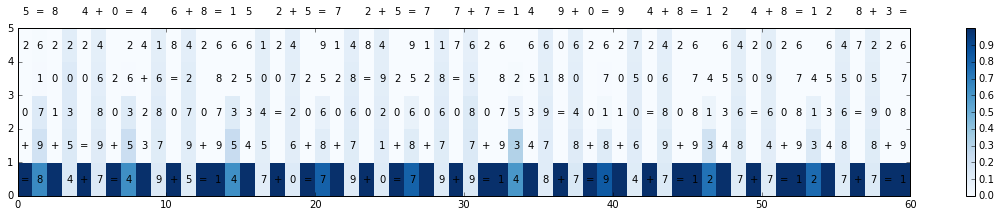

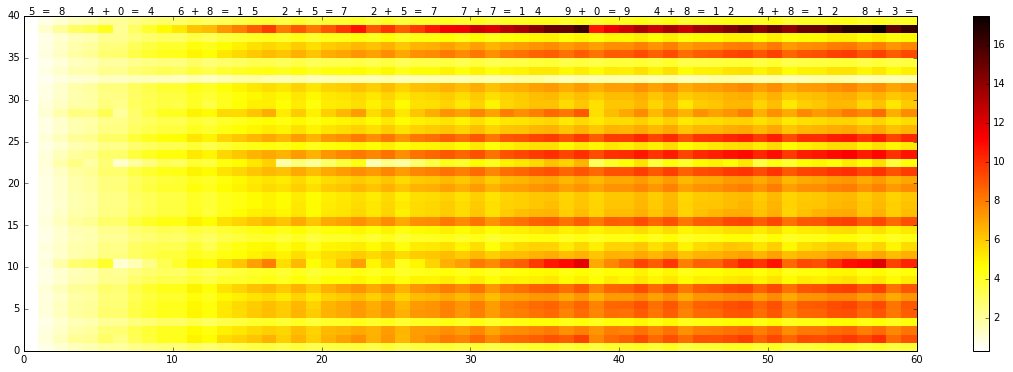

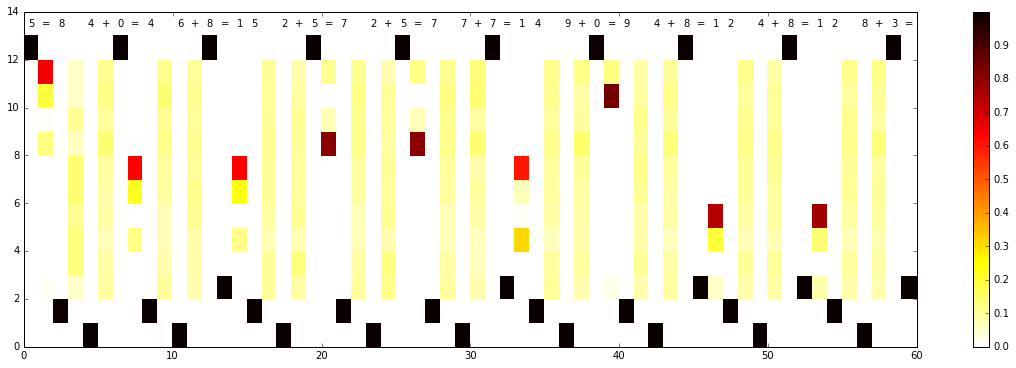

In [8]:
def sample_dist(l, sc, steps, prevs, prevh): 
    Xt = np.zeros([nc, 1])
    Xt[ char2idx[ sc ] ] = 1
    output = sc
    
    hh = np.zeros([hn, steps])
    ho = np.zeros([nc, steps])
    hd = np.zeros([l, steps])
    hc = np.chararray([l, steps])
    
    for t in range(steps):
        Gt = sigmoid(Wgx.dot(Xt) + Wgh.dot(prevh) + Bg)
        It = sigmoid(Wix.dot(Xt) + Wih.dot(prevh) + Bi)
        Ft = sigmoid(Wfx.dot(Xt) + Wfh.dot(prevh) + Bf)
        Ot = sigmoid(Wox.dot(Xt) + Woh.dot(prevh) + Bo) 
        
        St = Gt * It + prevs * Ft
  #      print np.linalg.norm(St)
        prevs = St
        Ht = sigmoid(St) * Ot
        prevh = Ht
        Akt = Wkh.dot(Ht) + Bk
        Ykt = softmax(Akt)
        
        hh[ :, t] = St.reshape([hn]) ## looking at firing rate
        ho[ :, t] = Ykt.reshape([nc]) ## looking at firing rate
        
        sortidx = np.argsort(np.ravel(-Ykt))
        hd[:, t] = Ykt[sortidx[0:l]].reshape(5)
        for n in range(l):
            hc[n, t] = idx2char[sortidx[n]] 
        
        idx = np.random.choice(nc, p = Ykt.reshape([len(Ykt)]))
        output += idx2char[idx]

        Xt = np.zeros_like(Xt)
        Xt[idx] = 1
    return output, hd, hc, hh, ho 

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

steps =60
numlargest = 5

prevs, prevh = np.zeros([hn, 1]), np.zeros([hn, 1])
output, hd, hc, hh, ho = sample_dist(numlargest, '5', steps, prevs, prevh)

fig = plt.figure(figsize=(20,3))
heatmap = plt.pcolor(hd,cmap=plt.cm.Blues)


y = numlargest
for x in range(hd.shape[1]):
    plt.text(x + 0.5, y + 0.5, '%s'% output[x] ,
        horizontalalignment='center',
        verticalalignment='center',
        )

for x in range(hd.shape[1]):
    for y in range(hd.shape[0]):
        plt.text(x + 0.5, y + 0.5, '%s'% hc[y,x] ,
            horizontalalignment='center',
            verticalalignment='center',
            )
    
plt.colorbar(heatmap)

plt.show()


fig = plt.figure(figsize=(20,6))
heatmap = plt.pcolor(hh,cmap='hot_r')

y = hn
for x in range(hh.shape[1]):
    plt.text(x + 0.5, y + 0.5, '%s'% output[x] ,
        horizontalalignment='center',
        verticalalignment='center',
        )
    
plt.colorbar(heatmap)

plt.show()


fig = plt.figure(figsize=(20,6))
heatmap = plt.pcolor(ho,cmap='hot_r')
y = nc
for x in range(ho.shape[1]):
    plt.text(x + 0.5, y + 0.5, '%s'% output[x] ,
        horizontalalignment='center',
        verticalalignment='center',
        )
    
plt.colorbar(heatmap)

plt.show()

- G(t) = sigma(Wgx * X(t) + Wgh * H(t-1) + Bg) # Input gate
- I(t) = sigma(Wix * X(t) + Wih * H(t-1) + Bi) # Input
- F(t) = sigma(Wfx * X(t) + Wfh * H(t-1) + Bf) # Forget gate
- O(t) = sigma(Wox * X(t) + Woh * H(t-1) + Bo) # Output gate
- S(t) = G(t) .* I(t) + S(t-1) .* F(t) 
- H(t) = sigma(S(t)) .* O(t)
- Ak(t) = Wkh * H(t) + Bk
- Yk(t) = softmax(Ak(t))